### MINI PROJECT: Sentiment Analysis using NLP

One of the key areas where NLP has been predominantly used is Sentiment analysis. The understanding of customer behavior and needs on a company’s products and services is vital for organizations. Generally, the feedback provided by a customer on a product can be categorized into POSITIVE, NEGATIVE, and NEUTRAL. Interpreting customer feedback through product reviews helps companies evaluate how satisfied the customers are with their products/services.

#### This dataset

We will use the IMDB Reviews dataset for mobile electronics. The dataset is available in the `tensorflow_datasets` package. We will download it from there before using it with our PyTorch pipeline.

In [1]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np

imdb_train = tfds.load('imdb_reviews/plain_text', split='train', shuffle_files=True)
imdb_train = tfds.as_dataframe(imdb_train)
print(imdb_train.head())

imdb_train_x = np.array([s.decode('utf-8') for s in imdb_train['text'].tolist()])
imdb_train_y = imdb_train['label'].to_numpy()
print(f"imdb_reviews(split='train'): x={len(imdb_train_x)}, y={len(imdb_train_y)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQPU65G/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQPU65G/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQPU65G/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
   label                                               text
0      0  b"This was an absolutely terrible movie. Don't...
1      0  b'I have been known to fall asleep during film...
2      0  b'Mann photographs the Alberta Rocky Mountains...
3      1  b'This is the kind of film for a snowy Sunday ...
4      1  b'As others have mentioned, all the women that...
imdb_reviews(split='train'): x=25000, y=25000


In [2]:
imdb_test = tfds.load('imdb_reviews/plain_text', split='test', shuffle_files=False)
imdb_test = tfds.as_dataframe(imdb_test)
print(imdb_test.head())

imdb_test_x = np.array([s.decode('utf-8') for s in imdb_test['text'].tolist()])
imdb_test_y = imdb_test['label'].to_numpy()
print(f"imdb_reviews(split='test'): x={len(imdb_test_x)}, y={len(imdb_test_y)}")

   label                                               text
0      1  b"There are films that make careers. For Georg...
1      1  b"A blackly comic tale of a down-trodden pries...
2      0  b'Scary Movie 1-4, Epic Movie, Date Movie, Mee...
3      0  b'Poor Shirley MacLaine tries hard to lend som...
4      1  b'As a former Erasmus student I enjoyed this f...
imdb_reviews(split='test'): x=25000, y=25000


Next step is to prepare the data for our task. In the downloaded dataset, each row has the text of the review and a five-star rating. 

We perform the following preprocessing steps:
1. Build Vocabulary
2. Create Embeddings


#### Step 1: Create Vocabulary
In our case, the text corpus consists of all the reviews in the training data.

In [3]:
text_corpus = ' '.join(imdb_train_x).lower()



We can see there are a lot of punctuation marks like fullstop(.), comma(,), new line (\n) and so on and we need to remove it as a part of the preprocessing. 

Here is a list of all the punctuation marks that will to be removed 
```
(!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~)
```


##### Removing punctuation


In [4]:
import re

def remove_punctuation(text):
    punct = r"[\d!\"#\$%&\'\(\)\*\+,-.\/:;<=>\?@\[\\\]\^_`{\|}~]"
    return re.sub(punct, '', text)

##### Removing stopwords

We can remove stop words like ‘the’, ‘and’, ‘I’, etc from the text in a given corpus to clean up the data, and identify words that are more rare and potentially more relevant to what we’re interested in.

In [5]:
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(text):
    nonsense = set(stopwords.words('english')) 
    for stopword in nonsense:
        text = text.replace(f' {stopword} ', ' ')
    return re.sub(r"\s+", ' ', text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
def cleanup(text):
    text_ = remove_punctuation(text)
    text_ = remove_stopwords(text_)
    return text_

text_corpus_clean = cleanup(text_corpus)

##### Tokenization

In [7]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenize(text):
    words = word_tokenize(text)
    return sorted(words)

words = tokenize(text_corpus_clean)
print("{} words in vocabulary ({} unique)".format(len(words), len(set(words))))
words[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


3083323 words in vocabulary (118239 unique)


['\x08\x08\x08\x08a', '\x10own', 'a', 'a', 'a']

In [8]:
from collections import Counter

# frequency = Counter(words)
# for word in words:  # remove words that only occur once (probably typos)
    # if frequency[word] == 1:
        # words.remove(word)

print("{} words in updated vocabulary ({} unique)".format(len(words), len(set(words))))
words[:5]

3083323 words in updated vocabulary (118239 unique)


['\x08\x08\x08\x08a', '\x10own', 'a', 'a', 'a']

In [9]:
vocab = sorted(list(set(words)))
print(len(vocab))
vocab[:5]

118239


['\x08\x08\x08\x08a', '\x10own', 'a', 'aa', 'aaa']

#### Step 2: Compute word embeddings
This involves mapping every word to an integer value and then vice-versa. 


In [10]:
# map each vocab word to an integer. Also, start the indexing with 1 as we will use 
# '0' for padding and we dont want to mix the two.
def vocabulary_to_integer(vocab):
    index = 1
    vocab_to_int = dict()
    for word in vocab:
        vocab_to_int[word] = index
        index += 1

    return vocab_to_int

vocab_to_int = vocabulary_to_integer(vocab)
print(len(vocab_to_int))

118239


Let's see what positve words in positive reviews we have and what we have in negative reviews. 

In [11]:
positive_counts = Counter()
negative_counts = Counter()

In [12]:
for review, label in zip(imdb_train_x, imdb_train_y):
    review = remove_stopwords(remove_punctuation(review))
    if label == 1:
        for word in review.split(" "):
              positive_counts[word] += 1
    else:
        for word in review.split(" "):
              negative_counts[word] += 1

In [13]:
positive_counts.most_common()[:5]

[('I', 33307),
 ('br', 27842),
 ('The', 22155),
 ('film', 19332),
 ('movie', 17911)]

In [14]:
negative_counts.most_common()[:5]

[('I', 37767),
 ('br', 29841),
 ('movie', 23290),
 ('The', 22227),
 ('film', 17681)]

The above just shows the most common words in the positive and negative sentences.
```

In [15]:
vocab_to_int['recommended']

84870

In [16]:
imdb_train_x_embed = []
for x in imdb_train_x:
    x = cleanup(x.lower())
    try:
        imdb_train_x_embed.append([vocab_to_int[word] for word in x.split(" ")])
    except KeyError: # this can happen because we removed stopwords
        pass # ignore this

imdb_test_x_embed = []
for x in imdb_test_x:
    x = cleanup(x.lower())
    try:
        imdb_test_x_embed.append([vocab_to_int[word] for word in x.split(" ")])
    except KeyError: # this can happen because we removed stopwords
        pass # ignore this

print(len(imdb_train_x_embed))
print(len(imdb_test_x_embed))

20208
4844


In [17]:
# This step is to see if any review is empty and we remove it. Otherwise the input will be all zeroes.
review_lens = Counter([len(x) for x in imdb_train_x_embed])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 0
Maximum review length: 897


In [18]:
# We remove any reviews/labels with zero length from the list
print('Number of reviews before removing outliers: ', len(imdb_train_x_embed))
non_zero_idx = [ii for ii, review in enumerate(imdb_train_x_embed) if len(review) != 0]
imdb_train_x_embed = [imdb_train_x_embed[ii] for ii in non_zero_idx]
imdb_train_y = np.array([imdb_train_y[ii] for ii in non_zero_idx])
print('Number of reviews after removing outliers: ', len(imdb_train_x_embed))
print('Number of labels after removing outliers: ', len(imdb_train_y))

Number of reviews before removing outliers:  20208
Number of reviews after removing outliers:  20208
Number of labels after removing outliers:  20208


In [19]:
print(imdb_train_x_embed[2])

[62754, 78062, 2312, 87883, 67966, 101160, 35871, 54368, 99169, 113024, 12651, 42005, 32595, 77358, 3064, 91595, 12253, 12253, 19699, 48173, 67975, 103498, 77154, 24653, 18260, 117487, 31584, 63294, 117111, 63294, 32472, 58264, 44315, 8384, 99907, 21313, 106620, 12253, 12253, 71801, 33729, 85908, 86364, 45429, 14802, 94306, 11807, 56578, 42515, 88888, 68415, 62754, 20084, 4746, 66571, 24653, 18260, 24827, 14802, 71664, 3281, 115050, 114333, 12253, 14802, 111980, 80877, 85140, 61940, 108484, 32595, 49118, 61258, 79091, 92976, 46153, 27852]


#### Step 3: Data padding

> Here, we define a function that returns an array `features` that contains the padded data, of a standard size, that we'll pass to the network. 
* We feed integers to the network. 
* Each row will be `seq_length` elements long. 
* For reviews shorter than `seq_length` words, we **left pad** with 0s.
* For reviews longer than `seq_length`, we use only the first `seq_length` words as the feature vector.

**The `features` array would be a 2D array, with as many rows as there are reviews, and as many columns as the specified `seq_length`.**

In [37]:
import numpy as np

# padding the data
def pad_features(reviews_ints, seq_length):
    features = []
    for review in reviews_ints:
        pad = seq_length - len(review)
        if pad > 0:
            for _ in range(pad):
                review.insert(0, 0)

        features.append(review[:seq_length])

    return np.array(features)

In [38]:
seq_length = 200
features = pad_features(imdb_train_x_embed, seq_length=seq_length)

print(features[:30,:10])

[[     0      0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0]
 [ 73210  46008  12253  77062  55739  66496  47055   8462   7095  32515]
 [     0      0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0]
 [ 37279 105579  82558  36962  12253  59833  56320 

#### Step 4: Create train/test splits

We can create train, test and val split in the ratio of 8:1:1.

In [22]:
from sklearn.model_selection import train_test_split

train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

def train_test_val_split(features):
    val_test_x, train_x = train_test_split(features, test_size=train_frac, shuffle=False)
    val_x, test_x = train_test_split(val_test_x, test_size=test_frac / (val_frac+test_frac), shuffle=False)
    return train_x, val_x, test_x

def train_test_val_labels(encoded_labels):
    val_test_y, train_y = train_test_split(encoded_labels, test_size=train_frac, shuffle=False)
    val_y, test_y = train_test_split(val_test_y, test_size=test_frac / (val_frac+test_frac), shuffle=False)
    return train_y, val_y, test_y

train_x, val_x, test_x = train_test_val_split(features)
train_y, val_y, test_y = train_test_val_labels(imdb_train_y)

In [23]:
## print out the shapes
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(16167, 200) 
Validation set: 	(2020, 200) 
Test set: 		(2021, 200)


In [24]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets for train, test and val
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 64

# make sure to SHUFFLE your training data. Keep Shuffle=True.
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, drop_last=True)

In [25]:
# print batches of training data and label. 
dataiter = iter(train_loader)
for batch_idx, (sample_x, sample_y) in enumerate(dataiter):

    print(f"Batch {batch_idx}:")
    print("Sample X shape:", sample_x.shape)
    print("Sample Y shape:", sample_y.shape)

Batch 0:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 1:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 2:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 3:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 4:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 5:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 6:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 7:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 8:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 9:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 10:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 11:
Sample X shape: torch.Size([64, 200])
Sample Y shape: torch.Size([64])
Batch 12:
Sample X shape: torch.Size([

In [26]:
# Check if GPU is available.
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


#### Step 5: Create the Network

Here we create a simple RNN and pass the output to the a Linear layer and Sigmoid at the end to get the probability score and prediction as POSITIVE or NEGATIVE. 

In [27]:
# RNN
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialization of the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # RNN layer
        self.rnn = nn.RNN(vocab_size, hidden_dim, n_layers, 
                          dropout=drop_prob, batch_first=True)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Performing a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # RNN out layer
        rnn_out, hidden = self.rnn(x, hidden)
    
        # stack up lstm outputs
        rnn_out = rnn_out.view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(rnn_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of RNN
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

    

In [28]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 1 # +1 for the 0 padding + our word tokens
output_size = 1
hidden_dim = 512
n_layers = 2

net = SentimentRNN(vocab_size, output_size, hidden_dim, n_layers)
print(net)

SentimentRNN(
  (rnn): RNN(118240, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)


##### Step 6: LSTM 

Trying out an LSTM for the same task.

We create a class named SentimentLSTM, and rest all hyperparameters same as before. Also, we create an embedding layer and feed the output of the embedding layer as input to the LSTM model. We also add a regularizer (dropout) layer after the LSTM layer with p=0.4 to prevent overfitting. 

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class SentimentLSTM(nn.Module):
    """
    The LSTM model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.4):
        """
        Initializing the model by setting up the layers.
        """
        super(SentimentLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # We need to get word embeddings before passing them to the LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)

        # The dropout layer regularizes our network
        self.dropout = nn.Dropout(drop_prob)

        # The linear layer that maps from hidden state space to tag space
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Performing a forward pass of our model on some input and hidden state.
        """
        n = x.size(0)
        x = x.long()

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(n, -1)[:,-1]
        return out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Creating two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [30]:
# Instantiate the model with these hyperparameters
vocab_size = len(vocab_to_int) + 1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 200
hidden_dim = 512
n_layers = 2

net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(118240, 200)
  (lstm): LSTM(200, 512, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


#### Step 7: Train the Network

##### Loss functions

We will usie `BCELoss (Binary Cross Entropy Loss)` since we have two output classes.

In [31]:
# Create loss function
criterion = nn.MSELoss()

# Create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

##### Perform training and validation

In [32]:
epochs = 5 
clip = 5 # gradient clipping

# move model to GPU, if available
if train_on_gpu:
    net.cuda()

train_losses = []
val_losses = []
for e in range(epochs):
    # Training loop
    h = net.init_hidden(batch_size)  # initialize hidden state
    net.train()
    loss_tr = None
    for inputs, labels in train_loader:  # batch loop
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # Training step
        net.zero_grad()                                     # zero accumulated gradients
        output, h = net(inputs, h)                          # forward pass
        loss = criterion(output.squeeze(), labels.float())  # compute loss
        loss.backward()                                     # backward pass
        loss_tr = loss if loss_tr is None else loss_tr+loss # accumulate loss
        nn.utils.clip_grad_norm_(net.parameters(), clip)    # `clip_grad_norm` helps
                                                            # prevent exploding gradients
        optimizer.step()                                    # update weights
    loss_tr /= len(train_loader)
    train_losses.append(loss_tr.item())

    # Validation loop
    val_h = net.init_hidden(batch_size)
    net.eval()
    loss_va = None
    for inputs, labels in valid_loader:
        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        val_h = tuple([each.data for each in val_h])

        # Validation step
        output, val_h = net(inputs, val_h)                  # forward pass
        loss = criterion(output.squeeze(), labels.float())  # compute loss
        loss_va = loss if loss_va is None else loss_va+loss # accumulate loss
    loss_va /= len(valid_loader)
    val_losses.append(loss_va.item())

    print("\r", "epoch: {}\t".format(e+1),
          "loss_tr: {:.6f}...".format(loss_tr.item()),
          "loss_va: {:.6f}".format(np.mean(loss_va.item())), end='')

 epoch: 5	 loss_tr: 0.470245... loss_va: 0.487291

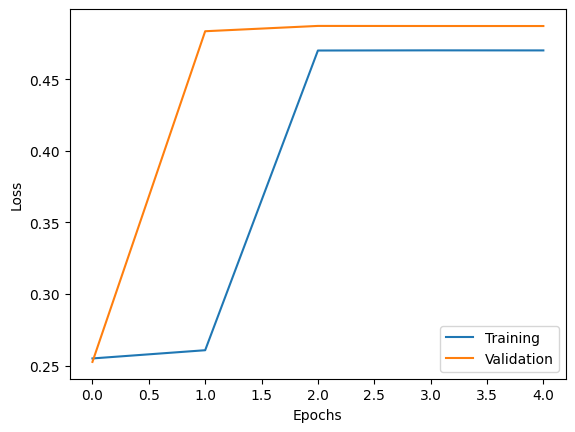

In [33]:
# Visualize the loss on training and validation set for the epochs

%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(range(len(train_losses)), train_losses, label='Training')
plt.plot(range(len(val_losses)), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()